<a href="https://colab.research.google.com/github/ShahedSabab/Blind-Reader/blob/master/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

     |████████████████████████████████| 573kB 2.7MB/s 
     |████████████████████████████████| 1.0MB 6.0MB/s 
     |████████████████████████████████| 3.7MB 13.3MB/s 
     |████████████████████████████████| 890kB 35.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=29265e4b4c6ce31de177bed9c6cb54ff731a4a2c3993a1930e97e7948e894446
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sacremoses


In [2]:
import transformers 
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pylab import rcParams
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
from torch import nn, optim 
from torch.utils import data
from collections import defaultdict
from textwrap import wrap
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 99
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Read and check data

In [3]:
df = pd.read_csv('app_reviews.csv')
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Daxle Collier,https://lh3.googleusercontent.com/-rivlmdNVmoU...,This is a very pretty app with the illusion of...,1,223,3.57.0,2020-04-22 23:42:06,NaN,NaN,most_relevant,com.getsomeheadspace.android
1,Hussam Fateen,https://lh3.googleusercontent.com/a-/AOh14Ghn4...,"There's no ""Waking Up"" segment in the app. The...",1,38,3.57.0,2020-04-09 12:31:33,NaN,NaN,most_relevant,com.getsomeheadspace.android
2,Bo Brooks,https://lh3.googleusercontent.com/a-/AOh14GhDn...,I am on a yearly subscription and since the la...,1,72,3.57.0,2020-04-07 01:09:34,NaN,NaN,most_relevant,com.getsomeheadspace.android
3,Staci Thomas,https://lh3.googleusercontent.com/-m4z-sbErDeg...,I loved this app for the three weeks that I ha...,1,41,3.57.0,2020-04-25 10:00:07,Sorry for the trouble logging in! Please send ...,2020-04-25 16:33:39,most_relevant,com.getsomeheadspace.android
4,Beezus Peterson-Presley,https://lh3.googleusercontent.com/a-/AOh14GjrL...,1st of all...the app gives you the option of c...,1,128,3.57.0,2020-04-14 20:29:05,NaN,NaN,most_relevant,com.getsomeheadspace.android


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11976 entries, 0 to 11975
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              11976 non-null  object
 1   userImage             11976 non-null  object
 2   content               11976 non-null  object
 3   score                 11976 non-null  int64 
 4   thumbsUpCount         11976 non-null  int64 
 5   reviewCreatedVersion  10988 non-null  object
 6   at                    11976 non-null  object
 7   replyContent          3484 non-null   object
 8   repliedAt             3484 non-null   object
 9   sortOrder             11976 non-null  object
 10  appId                 11976 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.0+ MB


Text(0.5, 0, 'review score')

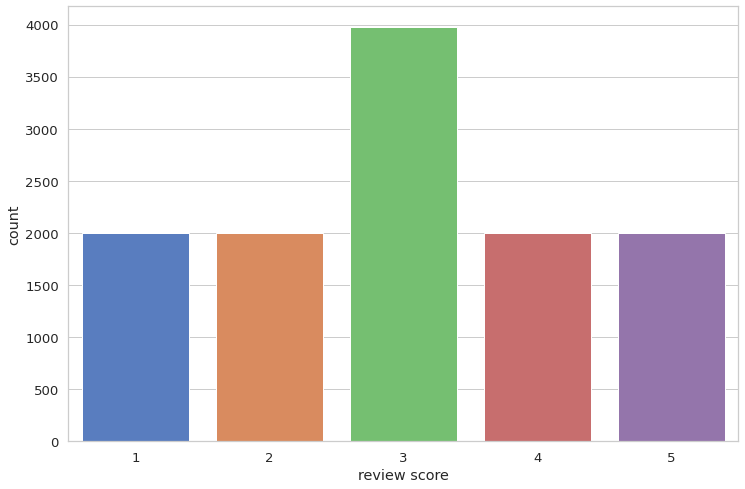

In [5]:
sns.countplot(df.score)
plt.xlabel('review score')

# Grop negative and positive sentiment

In [0]:
def groupRating(rating):
  grp_rating = -1
  rating = int(rating)
  if rating > 3:
    grp_rating = 2
  elif rating == 3:
    grp_rating = 1
  else:
    grp_rating = 0
  return grp_rating

In [0]:
df['sentiment'] = df.score.apply(groupRating)

[Text(0, 0, 'negative'), Text(0, 0, 'neutral'), Text(0, 0, 'positive')]

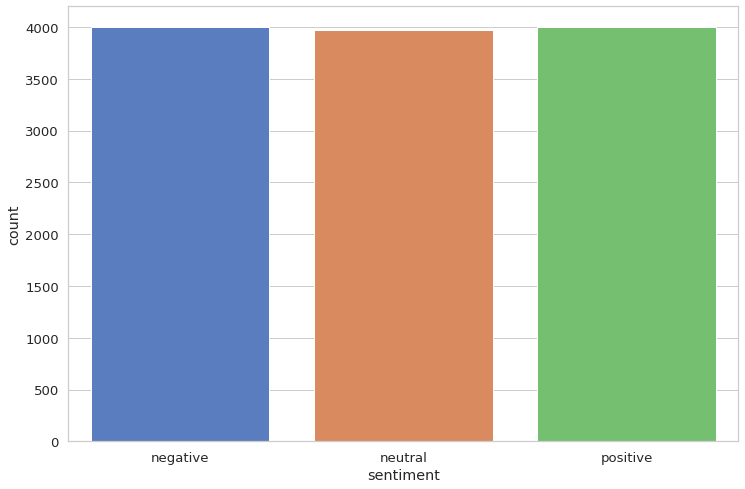

In [8]:
class_names = ['negative', 'neutral', 'positive']
ax = sns.countplot(df.sentiment)
plt.xlabel('sentiment')
ax.set_xticklabels(class_names)

# Background for processing

In [9]:
#download pretrained tokenizer from bert
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')

In [0]:
sample_text = "Just a test sentence. Test 2."
tokens = tokenizer.tokenize(sample_text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

In [11]:
print(f'Sample Text:{sample_text}')
print(f'Tokens     :{tokens}')
print(f'Token IDs  :{token_ids}')

Sample Text:Just a test sentence. Test 2.
Tokens     :['Just', 'a', 'test', 'sentence', '.', 'Test', '2', '.']
Token IDs  :[2066, 170, 2774, 5650, 119, 5960, 123, 119]


In [12]:
print(f'\t   Special Tokens')
print(f'-'*40)
print(f'     Separator Token:{tokenizer.sep_token} id:{tokenizer.sep_token_id}')
print(f'Classification Token:{tokenizer.cls_token} id:{tokenizer.cls_token_id}')
print(f'       Padding Token:{tokenizer.pad_token} id:{tokenizer.pad_token_id}')
print(f'       Unknown Token:{tokenizer.unk_token} id:{tokenizer.unk_token_id}')

	   Special Tokens
----------------------------------------
     Separator Token:[SEP] id:102
Classification Token:[CLS] id:101
       Padding Token:[PAD] id:0
       Unknown Token:[UNK] id:100


In [13]:
encoding = tokenizer.encode_plus(
    sample_text,
    max_length = 32,
    add_special_tokens=True,
    pad_to_max_length = True,
    return_attention_mask = True,
    return_token_type_ids=False,
    return_tensors='pt'
)
encoding

{'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0]]),
 'input_ids': tensor([[ 101, 2066,  170, 2774, 5650,  119, 5960,  123,  119,  102,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0]])}

# Data processing

In [0]:
token_length=[]
for content in df.content:
  tokens = tokenizer.encode(content)
  token_length.append(len(tokens))

Text(0.5, 0, 'length')

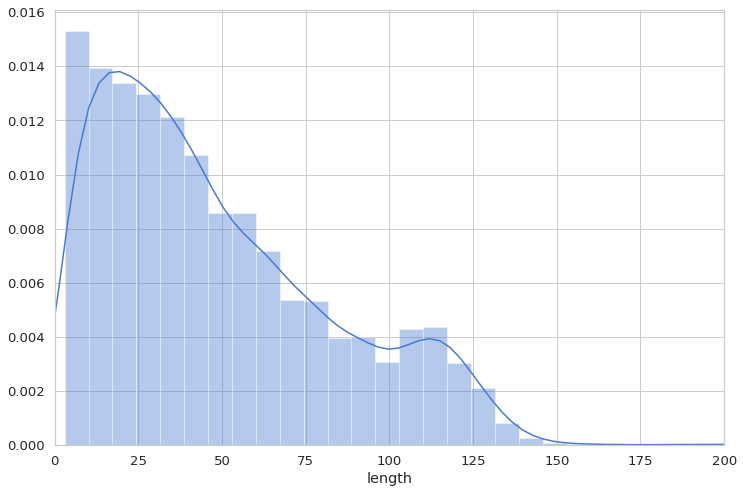

In [15]:
#check content's length distribution
ax = sns.distplot(token_length)
plt.xlim([0, 200]);
plt.xlabel('length')

# Create a Dataset

In [0]:
class reviewDataset(data.Dataset):
  def __init__(self, review, targets, tokenizer, max_len):
    self.review = review
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.review)

  def __getitem__(self, item):
    review = str(self.review[item])
    encoding = tokenizer.encode_plus(
      review,
      max_length = self.max_len,
      add_special_tokens=True,
      pad_to_max_length = True,
      return_attention_mask = True,
      return_token_type_ids=False,
      return_tensors='pt'
    )
    return {
        'review_text': review,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'targets': torch.tensor(self.targets[item], dtype = torch.long)
    }



# Initialization

In [0]:
# max length is set by considering the length distribution
MAX_LENGTH = 150
BATCH_SIZE = 16
EPOCHS = 40
LEARNING_RATE = 2e-5

# Train-test-val split

In [0]:
df_train, df_test = train_test_split(df, test_size = 0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size = 0.5, random_state=RANDOM_SEED)

In [0]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = reviewDataset(
      review = df.content.to_numpy(),
      targets = df.sentiment.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return data.DataLoader(
      ds,
      batch_size = batch_size,
      num_workers = 4
  )

In [0]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LENGTH, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LENGTH, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LENGTH, BATCH_SIZE)

In [21]:
data = next(iter(train_data_loader))
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 150])
torch.Size([16, 150])
torch.Size([16])


# Define Bert Model

In [22]:
bert_model = BertModel.from_pretrained("bert-base-cased")

In [0]:
last_hidden_state, pooled_output = bert_model(
    input_ids = encoding['input_ids'],
    attention_mask = encoding['attention_mask']
    )

In [24]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [25]:
pooled_output.shape

torch.Size([1, 768])

# Sentiment Classifier Model

In [0]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained("bert-base-cased")
    self.drop1 = nn.Dropout()
    self.fc1 = nn.Linear(self.bert.config.hidden_size, 100)
    self.fc2 = nn.Linear(100, n_classes)
    self.softmax = nn.Softmax(dim=1)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask
    )
    output = self.drop1(pooled_output)
    output = self.fc1(output)
    output = self.fc2(output)
    return self.softmax(output)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [28]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

#batch-size & max token length
print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 150])
torch.Size([16, 150])


In [29]:
model(input_ids, attention_mask)

tensor([[0.3361, 0.4137, 0.2502],
        [0.2745, 0.3456, 0.3799],
        [0.2804, 0.4309, 0.2887],
        [0.4472, 0.3940, 0.1588],
        [0.3675, 0.4281, 0.2044],
        [0.2466, 0.6008, 0.1527],
        [0.3976, 0.3158, 0.2866],
        [0.3891, 0.3447, 0.2662],
        [0.3401, 0.3406, 0.3193],
        [0.3681, 0.4142, 0.2177],
        [0.4020, 0.4413, 0.1568],
        [0.2672, 0.4823, 0.2505],
        [0.2870, 0.4880, 0.2250],
        [0.3541, 0.3966, 0.2493],
        [0.3149, 0.4463, 0.2388],
        [0.3640, 0.3653, 0.2707]], device='cuda:0', grad_fn=<SoftmaxBackward>)

# Training Process

In [0]:
#original Bert used AdamW: Adam algorithm with weight decay fix
optimizer = AdamW(model.parameters(), lr = LEARNING_RATE, correct_bias=False)
total_step = len(train_data_loader) * EPOCHS

#adjust learning rate
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_step
)

#define loss function
loss_fn = nn.CrossEntropyLoss().to(device)

In [0]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_prediction = 0

  for d in data_loader:
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    targets = d['targets'].to(device)
    outputs = model(
        input_ids = input_ids,
        attention_mask = attention_mask
    )

    _, preds = torch.max(outputs, dim = 1)
    loss = loss_fn(outputs, targets)

    correct_prediction += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_prediction.double() / n_examples, np.mean(losses)


In [0]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model.eval()
  losses = []
  correct_prediction = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d['input_ids'].to(device)
      attention_mask = d['attention_mask'].to(device)
      targets = d['targets'].to(device)
      outputs = model(
          input_ids = input_ids,
          attention_mask = attention_mask
      )

      _, preds = torch.max(outputs, dim = 1)
      loss = loss_fn(outputs, targets)

      correct_prediction += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_prediction.double() / n_examples, np.mean(losses)


In [33]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
  print(f'Epoch {epoch+1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
  print(f'Train loss {train_loss} Train accuracy {train_acc}')

  val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))
  print(f'Val loss {val_loss} Val accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)

  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'model.bin')
    best_accuracy = val_acc

Epoch 1/40
----------


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


Train loss 0.9305590206331599 Train accuracy 0.5988123956207089
Val loss 0.8818289229744359 Val accuracy 0.6444073455759599

Epoch 2/40
----------
Train loss 0.8090376990131525 Train accuracy 0.73622193356838
Val loss 0.8461066468765861 Val accuracy 0.6961602671118531

Epoch 3/40
----------
Train loss 0.7438108129565015 Train accuracy 0.8061792540359992
Val loss 0.8275917831220125 Val accuracy 0.7195325542570952

Epoch 4/40
----------
Train loss 0.720367973653782 Train accuracy 0.8293746520690295
Val loss 0.8322581742939196 Val accuracy 0.7128547579298832

Epoch 5/40
----------
Train loss 0.7039427814745408 Train accuracy 0.8460753386528113
Val loss 0.803064901577799 Val accuracy 0.7412353923205343

Epoch 6/40
----------
Train loss 0.6910693598607174 Train accuracy 0.8590647615513082
Val loss 0.8093251664387552 Val accuracy 0.7429048414023373

Epoch 7/40
----------
Train loss 0.6818435207141966 Train accuracy 0.8687140471330488
Val loss 0.8014889108507257 Val accuracy 0.742904841402337

In [0]:
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('model.bin'))
model = model.to(device)

# Evaluation

In [0]:
def get_reviews(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      texts = d['review_text']
      input_ids = d['input_ids'].to(device)
      attention_mask = d['attention_mask'].to(device)
      targets = d['targets'].to(device)
      outputs = model(
          input_ids = input_ids,
          attention_mask = attention_mask
      )

      _, preds = torch.max(outputs, dim = 1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()

  return review_texts, predictions, prediction_probs, real_values

In [0]:
test_acc, test_loss = eval_model(model, test_data_loader, loss_fn, device, len(df_test))

In [0]:
y_review_texts, y_pred, y_pred_probs, y_test = get_reviews(model, test_data_loader)

In [38]:
print(classification_report(y_test, y_pred, target_names = class_names))

              precision    recall  f1-score   support

    negative       0.83      0.85      0.84       219
     neutral       0.70      0.74      0.72       183
    positive       0.87      0.81      0.84       197

    accuracy                           0.80       599
   macro avg       0.80      0.80      0.80       599
weighted avg       0.81      0.80      0.81       599



In [0]:
#confusion matrix heatmap
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot = True, fmt = "d", cmap = "Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation = 0, ha = "right")
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation = 30, ha = "right")
  plt.ylabel('True Sentiment')
  plt.xlabel('Predicted Sentiment')

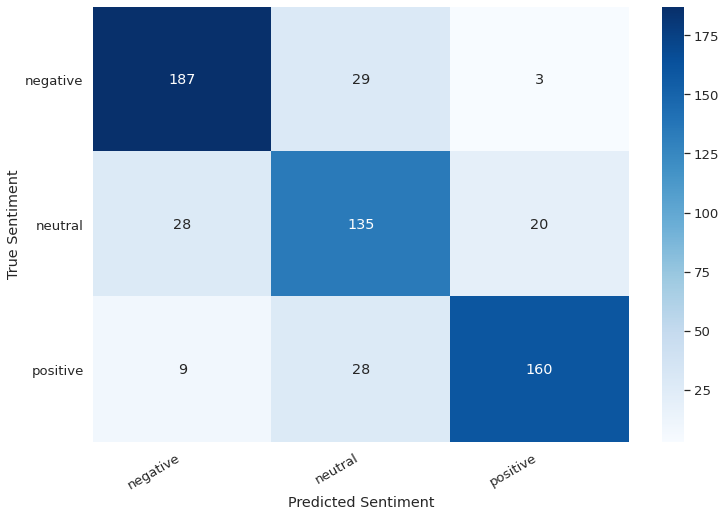

In [40]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index = class_names, columns = class_names)
show_confusion_matrix(df_cm)

In [0]:
# check review 

idx = 3

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]

pred_df = pd.DataFrame(
    {
        'class_names': class_names,
        'values': y_pred_probs[idx]
    }
)

In [50]:
print("\n".join(wrap(review_text)))
print()
print(f'True Sentiment: {class_names[true_sentiment]}')

I can't use this app at the moment. Every time I try and do anything
the premium ad pops up asking if I want premium. No. I don't! I just
want to use it... will uninstall until th next update. Hopefully it
fixed itself

True Sentiment: negative


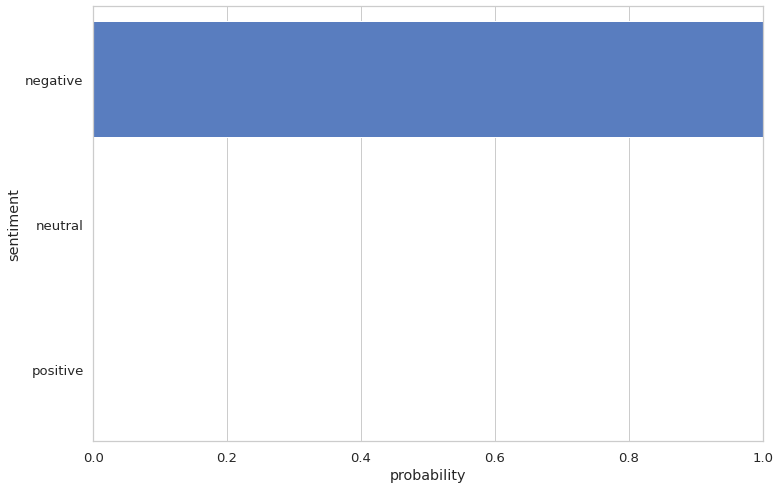

In [51]:
sns.barplot(x='values', y='class_names', data = pred_df, orient = 'h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0,1]);

# Sentiment on Raw Text

In [0]:
review_text = 'I love this health tracker. It has made me very active'

In [0]:
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length = MAX_LENGTH,
    add_special_tokens= True,
    return_token_type_ids = False,
    pad_to_max_length = True,
    return_attention_mask = True,
    return_tensors = 'pt'
)

In [0]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

In [0]:
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim = 1)

In [56]:
print(f'Review Text: {review_text}')
print(f'Sentiment: {class_names[prediction]}')

Review Text: I love this health tracker. It has made me very active
Sentiment: positive
